# Modeling and Simulation in Python

Case study: Spider-Man

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *


I'll start by getting the units we'll need from Pint.

In [2]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
N = UNITS.newton
degree = UNITS.degree
radian = UNITS.radian

<Unit('radian')>

### Spider-Man

In this case study we'll develop a model of Spider-Man swinging from a springy cable of webbing attached to the top of the Empire State Building.  Initially, Spider-Man is at the top of a nearby building, as shown in this diagram.

![](diagrams/spiderman.png)

The origin, `O`, is at the base of the Empire State Building.  The vector `H` represents the position where the webbing is attached to the building, relative to `O`.  The vector `P` is the position of Spider-Man relative to `O`.  And `L` is the vector from the attachment point to Spider-Man.

By following the arrows from `O`, along `H`, and along `L`, we can see that 

`H + L = P`

So we can compute `L` like this:

`L = P - H`

The goals of this case study are:

1. Implement a model of this scenario to predict Spider-Man's trajectory.

2. Choose the right time for Spider-Man to let go of the webbing in order to maximize the distance he travels before landing.

3. Choose the best angle for Spider-Man to jump off the building, and let go of the webbing, to maximize range.

I'll create a `Params` object to contain the quantities we'll need:

1. According to [the Spider-Man Wiki](http://spiderman.wikia.com/wiki/Peter_Parker_%28Earth-616%29), Spider-Man weighs 76 kg.

2. Let's assume his terminal velocity is 60 m/s.

3. The length of the web is 100 m.

4. The initial angle of the web is 45 degrees to the left of straight down.

5. The spring constant of the web is 40 N / m when the cord is stretched, and 0 when it's compressed.

Here's a `Params` object.

In [3]:
params = Params(height = 381 * m,
                g = 9.8 * m/s**2,
                mass = 75 * kg,
                area = 1 * m**2,
                rho = 1.2 * kg/m**3,
                v_term = 60 * m / s,
                length = 100 * m,
                angle = (270 - 45) * degree,
                k = 40 * N / m,
                t_0 = 0 * s,
                t_end = 30 * s)

,values
height,381 meter
g,9.8 meter / second ** 2
mass,75 kilogram
area,1 meter ** 2
rho,1.2 kilogram / meter ** 3
v_term,60.0 meter / second
length,100 meter
angle,225 degree
k,40.0 newton / meter
t_0,0 second


Now here's a version of `make_system` that takes a `Params` object as a parameter.

`make_system` uses the given value of `v_term` to compute the drag coefficient `C_d`.

In [4]:
def make_system(params):
    """Makes a System object for the given conditions.
    
    params: Params object
    
    returns: System object
    """
    P_0, V_0 = params.P_0, params.V_0
    mass, g = params.mass, params.g
    rho, area, v_term = params.rho, params.area, params.v_term
    
    init = State(x=P_0.x, y=P_0.y, vx=V_0.x, vy=V_0.y)
    C_d = 2 * mass * g / (rho * area * v_term**2)    
    
    return System(params, init=init, C_d=C_d)

Compute the initial position

In [5]:
def compute_initial_condition(params):
    """Compute the initial values of L and P.
    """
    height, length, angle = params.height, params.length, params.angle
    
    H = Vector(0, height)
    theta = angle.to(radian)
    x, y = pol2cart(theta, length)
    L_0 = Vector(x, y)
    P_0 = H + L_0
    V_0 = Vector(0, 0) * m/s
    
    params.set(P_0=P_0, V_0=V_0)

In [6]:
compute_initial_condition(params)
params.P_0

array([-70.71067812, 310.28932188]) <Unit('meter')>

In [7]:
params.V_0

array([0., 0.]) <Unit('meter / second')>

Let's make a `System`

In [8]:
system = make_system(params)

,values
height,381 meter
g,9.8 meter / second ** 2
mass,75 kilogram
area,1 meter ** 2
rho,1.2 kilogram / meter ** 3
v_term,60.0 meter / second
length,100 meter
angle,225 degree
k,40.0 newton / meter
t_0,0 second


In [9]:
system.init

,values
x,-70.71067811865477 meter
y,310.28932188134524 meter
vx,0.0 meter / second
vy,0.0 meter / second


### Drag and spring forces

Here's drag force, as we saw in Chapter 22.

In [10]:
def drag_force(V, system):
    """Compute drag force.
    
    V: velocity Vector
    system: `System` object
    
    returns: force Vector
    """
    unpack(system)
    mag = rho * V.mag**2 * C_d * area / 2
    direction = -V.hat()
    f_drag = direction * mag
    return f_drag

In [11]:
V_test = Vector(10, 10) * m/s

array([10., 10.]) <Unit('meter / second')>

In [12]:
drag_force(V_test, system)

array([-28.8735269, -28.8735269]) <Unit('kilogram * meter / second ** 2')>

And here's the 2-D version of spring force.  We saw the 1-D version in Chapter 21.

In [13]:
def spring_force(L, system):
    """Compute drag force.
    
    L: Vector representing the webbing
    system: System object
    
    returns: force Vector
    """
    unpack(system)
    
    extension = L.mag - length
    if magnitude(extension) < 0:
        mag = 0
    else:
        mag = k * extension
        
    direction = -L.hat()
    f_spring = direction * mag
    return f_spring

In [14]:
L_test = Vector(0, -system.length-1*m)

array([   0, -101]) <Unit('meter')>

In [15]:
f_spring = spring_force(L_test, system)

array([-0., 40.]) <Unit('newton')>

Here's the slope function, including acceleration due to gravity, drag, and the spring force of the webbing.

In [16]:
def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy = state
    unpack(system)
    
    H = Vector(0, height)
    P = Vector(x, y)
    V = Vector(vx, vy)
    L = P - H
    
    a_grav = Vector(0, -g)
    a_spring = spring_force(L, system) / mass
    a_drag = drag_force(V, system) / mass
    
    a = a_grav + a_drag + a_spring
    
    return vx, vy, a.x, a.y

As always, let's test the slope function with the initial conditions.

In [17]:
slope_func(system.init, 0, system)

(0.0 <Unit('meter / second')>,
 0.0 <Unit('meter / second')>,
 5.359248925640619e-15 <Unit('meter / second ** 2')>,
 -9.799999999999995 <Unit('meter / second ** 2')>)

And then run the simulation.

In [18]:
%time results, details = run_ode_solver(system, slope_func, max_step=0.3)
details

CPU times: user 735 ms, sys: 7.15 ms, total: 742 ms
Wall time: 737 ms


,values
sol,None
t_events,[]
nfev,626
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


### Visualizing the results

We can extract the x and y components as `Series` objects.

The simplest way to visualize the results is to plot x and y as functions of time.

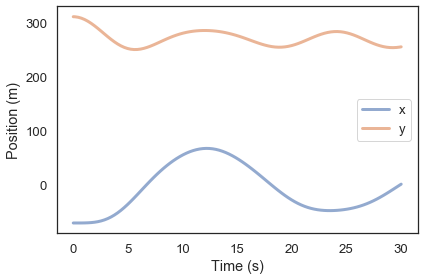

In [19]:
def plot_position(results):
    plot(results.x, label='x')
    plot(results.y, label='y')

    decorate(xlabel='Time (s)',
             ylabel='Position (m)')
    
plot_position(results)

We can plot the velocities the same way.

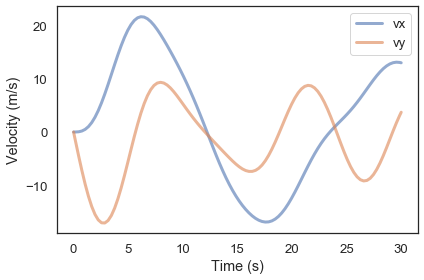

In [20]:
def plot_velocity(results):
    plot(results.vx, label='vx')
    plot(results.vy, label='vy')

    decorate(xlabel='Time (s)',
             ylabel='Velocity (m/s)')
    
plot_velocity(results)

Another way to visualize the results is to plot y versus x.  The result is the trajectory through the plane of motion.

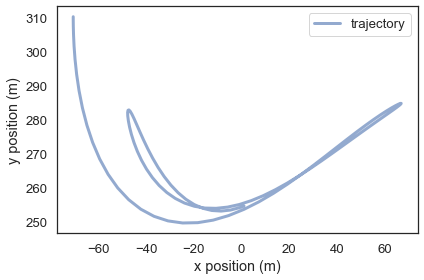

In [21]:
def plot_trajectory(results):
    plot(results.x, results.y, label='trajectory')

    decorate(xlabel='x position (m)',
             ylabel='y position (m)')
    
plot_trajectory(results)

### Letting go

Now let's find the optimal time for Spider-Man to let go.  We have to run the simulation in two phases because the spring force changes abruptly when Spider-Man lets go, so we can't integrate through it.

Here are the parameters for Phase 1, running for 9 seconds.

CPU times: user 200 ms, sys: 4.02 ms, total: 204 ms
Wall time: 200 ms


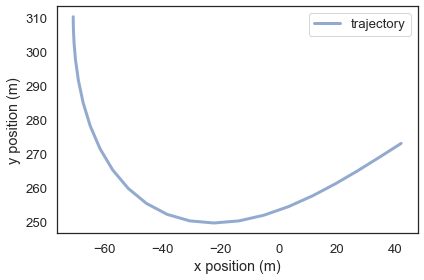

In [22]:
params1 = Params(params, t_end=9*s)
system1 = make_system(params1)
%time results1, details1 = run_ode_solver(system1, slope_func, max_step=0.4)
plot_trajectory(results1)

The final conditions from Phase 1 are the initial conditions for Phase 2.

In [23]:
t_final = get_last_label(results1) * s

9.0 <Unit('second')>

Here's the position Vector.

In [24]:
x, y, vx, vy = get_last_value(results1)
P_0 = Vector(x, y) * m

array([ 42.05516926, 273.03727598]) <Unit('meter')>

And the velocity Vector.

In [25]:
V_0 = Vector(vx, vy) * m/s

array([14.62716281,  7.96404255]) <Unit('meter / second')>

Here are the parameters for Phase 2.  We can turn off the spring force by setting `k=0`, so we don't have to write a new slope function.

In [26]:
params2 = Params(params1, t_0=t_final, t_end=t_final+10*s, P_0=P_0, V_0=V_0, k=0)
system2 = make_system(params2)

,values
height,381 meter
g,9.8 meter / second ** 2
mass,75 kilogram
area,1 meter ** 2
rho,1.2 kilogram / meter ** 3
v_term,60.0 meter / second
length,100 meter
angle,225 degree
k,0
t_0,9.0 second


Here's an event function that stops the simulation when Spider-Man reaches the ground.

In [27]:
def event_func(state, t, system):
    """Stops when y=0.
    
    state: State object
    t: time
    system: System object
    
    returns: height
    """
    x, y, vx, xy = state
    return y

Run Phase 2.

In [28]:
%time results2, details2 = run_ode_solver(system2, slope_func, events=event_func, max_step=0.4)

CPU times: user 225 ms, sys: 4.11 ms, total: 229 ms
Wall time: 226 ms


Plot the results.

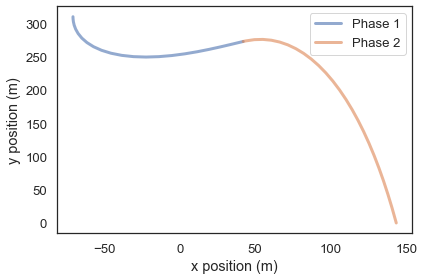

In [29]:
plot(results1.x, results1.y, label='Phase 1')
plot(results2.x, results2.y, label='Phase 2')

decorate(xlabel='x position (m)',
         ylabel='y position (m)')

Now we can gather all that into a function that takes `t_release` and `V_0`, runs both phases, and returns the results.

In [30]:
def run_two_phase(t_release, V_0, params):
    """Run both phases.
    
    t_release: time when Spider-Man lets go of the webbing
    V_0: initial velocity
    """
    params1 = Params(params, t_end=t_release, V_0=V_0)
    system1 = make_system(params1)
    results1, details1 = run_ode_solver(system1, slope_func, max_step=0.4)

    t_final = get_last_label(results1) * s
    x, y, vx, vy = get_last_value(results1)
    P_0 = Vector(x, y) * m
    V_0 = Vector(vx, vy) * m/s

    params2 = Params(params1, t_0=t_final, t_end=3*t_final,
                     P_0=P_0, V_0=V_0, k=0)
    system2 = make_system(params2)

    results2, details2 = run_ode_solver(system2, slope_func, events=event_func, max_step=0.4)

    results = results1.combine_first(results2)
    return results

And here's a test run.

143.43807371928114 <Unit('meter')>

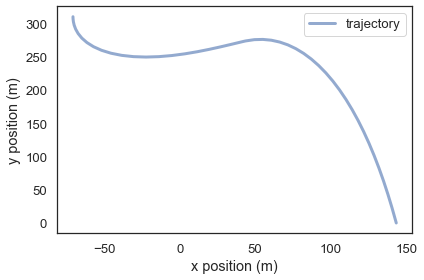

In [31]:
t_release = 9 * s
V_0 = Vector(0, 0) * m/s

results = run_two_phase(t_release, V_0, params)
plot_trajectory(results)
x_final = get_last_value(results.x) * m

### Maximizing range

To find the best value of `t_release`, we need a function that takes possible values, runs the simulation, and returns the range.

In [32]:
def range_func(t_release, params):
    V_0 = Vector(0, 0) * m/s
    results = run_two_phase(t_release, V_0, params)
    x_final = get_last_value(results.x) * m
    return x_final

We can test it.

In [33]:
range_func(9*s, params)

143.43807371928114 <Unit('meter')>

And run it for a few values.

In [34]:
for t_release in linrange(3, 15, 3) * s:
    print(t_release, range_func(t_release, params))

3 second -26.689268314945377 meter
6 second 116.08097143921458 meter
9 second 143.43807371928114 meter
12 second 74.59703591943536 meter


Now we can use `maximize_scalar` to find the optimum.

In [35]:
maximize_scalar(range_func, [6, 12], params)

,values
fun,149.50678396065007 meter
status,0
success,True
message,Solution found.
x,7.95963014265963 dimensionless
nfev,9


Finally, we can run the simulation with the optimal value.

149.4960697736888 <Unit('meter')>

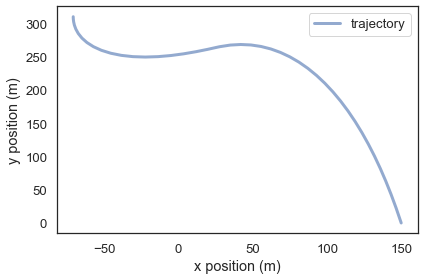

In [36]:
V_0 = Vector(0, 0) * m/s
results = run_two_phase(8*s, V_0, params)
plot_trajectory(results)
x_final = get_last_value(results.x) * m

### Taking a flying leap

Now suppose Spider-Man can jump off the wall in any direction at a maximum speed of 20 meters per second.  In what direction should he jump, and what time should he let go, to maximize the distance he travels?

Before you go on, think about it and see what you think the optimal angle is.

Here's a new range function that takes a guess as a parameter, where `guess` is a sequence of three values: `t_release`, launch velocity, and launch angle.

It computes `V_0`, runs the simulation, and returns the final `x` position.

In [37]:
def range_func2(guess, params):
    t_release, velocity, theta = guess
    print(t_release, velocity, theta)
    
    V_0 = Vector(pol2cart(theta, velocity))
    
    results = run_two_phase(t_release, V_0, params)
    x_final = get_last_value(results.x)
    return -x_final

We can test it with the conditions from the previous section.

In [38]:
x0 = 8*s, 0*m/s, 0*radian
range_func2(x0, params)

8 second 0.0 meter / second 0 radian


-149.4960697736888

Now we can use `minimize` to find the optimal values for `t_release`, launch velocity, and launch angle.  It takes a while to run because it has to search a 3-D space.

In [39]:
guess = [8, 15, -1]
bounds = [(0,20), (0,20), (-np.pi, np.pi)]

res = minimize(range_func2, guess, params, bounds=bounds)

8.0 15.0 -1.0
8.00000001 15.0 -1.0
8.0 15.00000001 -1.0
8.0 15.0 -0.99999999
0.0 13.73474223477379 -3.141592653589793
1e-08 13.73474223477379 -3.141592653589793
0.0 13.734742244773791 -3.141592653589793
0.0 13.73474223477379 -3.141592643589793
7.361323722480478 14.898988735050333 -1.1709730529947355
7.361323732480478 14.898988735050333 -1.1709730529947355
7.361323722480478 14.898988745050334 -1.1709730529947355
7.361323722480478 14.898988735050333 -1.1709730429947356
3.680661861240239 14.31686548491206 -2.1562828532922644
3.680661871240239 14.31686548491206 -2.1562828532922644
3.680661861240239 14.316865494912062 -2.1562828532922644
3.680661861240239 14.31686548491206 -2.1562828432922645
6.422687820438259 14.750536689577954 -1.422245022020891
6.422687830438259 14.750536689577954 -1.422245022020891
6.422687820438259 14.750536699577955 -1.422245022020891
6.422687820438259 14.750536689577954 -1.4222450120208912
7.016833474676373 14.888085058547777 -2.000129002973673
7.016833484676373 14.8

,values
fun,-176.49
jac,"[0.00024158453015843406, -1.7867023416329175, ..."
nfev,60
nit,11
status,0
message,b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPS...
x,"[6.949145522461682, 20.0, -1.9860011815728504]"
success,True
hess_inv,<3x3 LbfgsInvHessProduct with dtype=float64>


Here are the optimal values.

In [40]:
t_release, velocity, theta = res.x
V_0 = Vector(pol2cart(theta, velocity))

array([ -8.06754776, -18.30067412]) <Unit('dimensionless')>

It turns out that the best angle is down and to the left.  Not obvious.

In [41]:
V_0.mag

20.0 <Unit('dimensionless')>

Here's what the trajectory looks like with the optimal values.

176.49007259485504

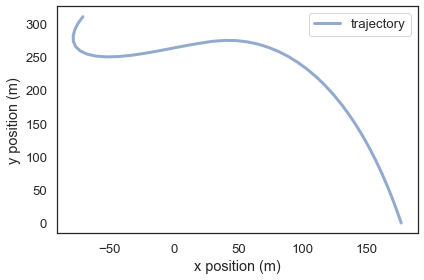

In [42]:
results = run_two_phase(t_release, V_0, params)
plot_trajectory(results)
x_final = get_last_value(results.x)